# 1. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Neural Network
from keras.layers import Dense, Input, Rescaling, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import ShuffleSplit, RandomizedSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Preprocessing
from sklearn.pipeline import Pipeline

# Cross-validation:
from sklearn.model_selection import KFold, cross_validate, train_test_split, cross_val_predict, StratifiedKFold

# Metrics
from sklearn.metrics import make_scorer, PredictionErrorDisplay, accuracy_score, precision_score, f1_score, recall_score, balanced_accuracy_score, roc_auc_score
# Confusion Matrix:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Hyperparameters optimization:
from sklearn.model_selection import GridSearchCV



# 2. Import Dataset

In [2]:
df = pd.read_csv('data/vaccines_features.csv', sep=',')

### To do more manageable the dataset, we'll reduce it until 30%.

In [3]:
sample_df = df.sample(frac=0.3, replace=False, random_state=42)

# 3. Cross Validation

In [4]:
# CV for classical ML
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# NN: Perform a single train-validation split
ss = ShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=42)

In [5]:
# For ML:

## Declare scores to be used
scores = {
    "roc_auc": make_scorer(roc_auc_score, needs_proba=True),
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "accuracy": make_scorer(accuracy_score)
}
## Print Metrics
def print_metrics(cv_results):
    for sc in scores.keys():
        print(f"Train {sc}: {round(cv_results[f'train_{sc}'].mean() * 100, 1)}%")
    print()
    for sc in scores.keys():
        print(f"Validation {sc}: {round(cv_results[f'test_{sc}'].mean() * 100, 1)}%")


c:\Users\Alumne_mati1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


# Split Train and Test:

In [6]:
X_raw = sample_df.drop(["h1n1_vaccine","seasonal_vaccine"], axis=1)
y_raw = sample_df[["h1n1_vaccine", "seasonal_vaccine"]]

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, shuffle=False)

In [7]:
def show_conf_matrix(rs_model, X_train, y_train, X_val, y_val):
    # Train best model on full train set
    rs_model.best_estimator_.fit(X_train, y_train)

    # Get predictions on validation set
    y_val_preds = rs_model.best_estimator_.predict(X_val)

    # Display confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_val, y_val_preds)
    plt.title('Validation')
    if y_train == y_train_raw["h1n1_vaccine"]:
        plt.xticks(range(2), "h1n1_vaccine")
        plt.yticks(range(2), "h1n1_vaccine")
    elif y_train == y_train_raw["seasonal_vaccine"]:
        plt.xticks(range(2), "seasonal_vaccine")
        plt.yticks(range(2), "seasonal_vaccine")
    plt.show()

# H1N1 Vaccine:
## Baseline: RF
We have already train several models with classical ML, where the winner was a RF with the below metrics that we'll try to beat with the Neural Network:

In [8]:
brf1 = BalancedRandomForestClassifier(bootstrap=True, sampling_strategy="auto", replacement=False)
brf1_cv = cross_validate(brf1, X_train_raw, y_train_raw["h1n1_vaccine"].values.ravel(), cv=kf, scoring=scores, return_train_score=True)

print_metrics(brf1_cv)

Train roc_auc: 99.9%
Train balanced_accuracy: 94.4%
Train precision: 70.7%
Train recall: 100.0%
Train f1: 82.8%
Train accuracy: 91.2%

Validation roc_auc: 85.9%
Validation balanced_accuracy: 78.7%
Validation precision: 51.3%
Validation recall: 77.1%
Validation f1: 61.6%
Validation accuracy: 79.6%


## Neural Network Model

In [9]:
from sklearn.utils import class_weight
class_weights = {0: 1,
                1: 3}

In [10]:
# define the keras model
model = Sequential()
model.add(Input(shape=(X_train_raw.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['auc'])

# fit the keras model on the dataset
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

results1 = model.fit(X_train_raw, pd.get_dummies(y_train_raw["h1n1_vaccine"]), epochs=300, batch_size=64,
                     validation_split=0.15, callbacks=[es], class_weight=class_weights)


# evaluate the keras model
_, auc1 = model.evaluate(X_test_raw, pd.get_dummies(y_test_raw["h1n1_vaccine"]))
print('Test auc: %.2f' % (auc1*100))

Epoch 1/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.6548 - loss: 0.9853 - val_auc: 0.6659 - val_loss: 0.6660
Epoch 2/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6692 - loss: 0.9761 - val_auc: 0.6981 - val_loss: 0.6572
Epoch 3/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6993 - loss: 0.9652 - val_auc: 0.7315 - val_loss: 0.6466
Epoch 4/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7416 - loss: 0.9463 - val_auc: 0.7760 - val_loss: 0.6295
Epoch 5/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7536 - loss: 0.9410 - val_auc: 0.7952 - val_loss: 0.6161
Epoch 6/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7868 - loss: 0.9120 - val_auc: 0.8217 - val_loss: 0.5932
Epoch 7/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8110 - loss: 0.8836 - val_auc: 0.8222 - val_loss: 0.5798
Epoch 8/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8122 - loss: 0.8678 - val_auc: 0.8485 - val_loss: 0.5487
Epoch 9/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8414

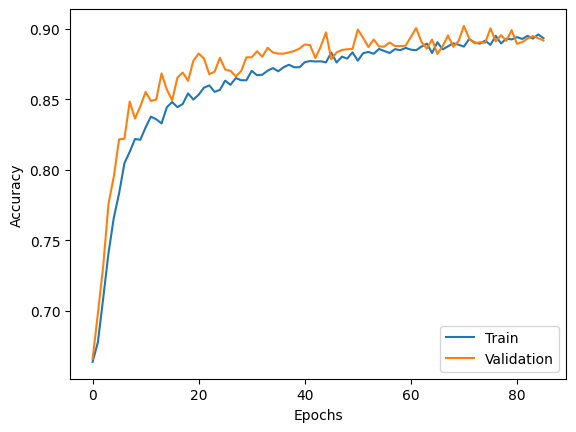

In [11]:
# Visualize the training metrics over the epochs
plt.plot(results1.history['auc'], label='Train')
plt.plot(results1.history['val_auc'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Let's try adding more complexity to our model by adding more neurons:

In [12]:
# define the keras model
model2 = Sequential()
model2.add(Input(shape=(X_train_raw.shape[1],)))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(2, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['auc'])

# fit the keras model on the dataset
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

results2 = model2.fit(X_train_raw, pd.get_dummies(y_train_raw["h1n1_vaccine"]), epochs=300, batch_size=64,
                     validation_split=0.15, callbacks=[es], class_weight=class_weights)


# evaluate the keras model
_, auc2 = model2.evaluate(X_test_raw, pd.get_dummies(y_test_raw["h1n1_vaccine"]))
print('Test AUC: %.2f' % (auc2*100))

Epoch 1/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.2534 - loss: 1.5301 - val_auc: 0.2444 - val_loss: 0.9024
Epoch 2/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.2718 - loss: 1.0320 - val_auc: 0.6098 - val_loss: 0.6815
Epoch 3/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6490 - loss: 0.9565 - val_auc: 0.7790 - val_loss: 0.6277
Epoch 4/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7694 - loss: 0.9157 - val_auc: 0.7830 - val_loss: 0.6139
Epoch 5/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7612 - loss: 0.8953 - val_auc: 0.8105 - val_loss: 0.5844
Epoch 6/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7805 - loss: 0.8746 - val_auc: 0.8079 - val_loss: 0.5728
Epoch 7/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7824 - loss: 0.8547 - val_auc: 0.8341 - val_loss: 0.5430
Epoch 8/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7981 - loss: 0.8391 - val_auc: 0.8489 - val_loss: 0.5189
Epoch 9/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8309

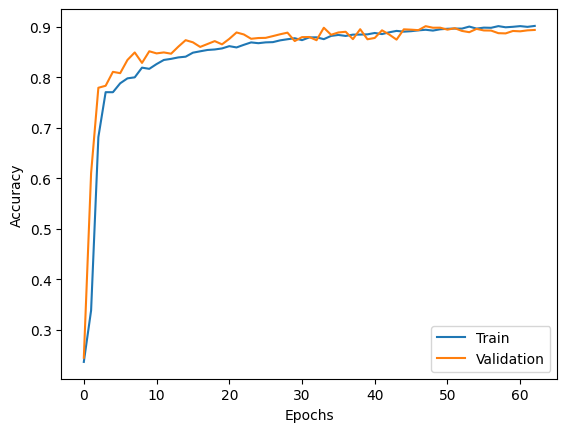

In [13]:
# Visualize the training metrics over the epochs
plt.plot(results2.history['auc'], label='Train')
plt.plot(results2.history['val_auc'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Apparently, it has improved a tiny bit, but it's a bit more unestable.

In [14]:
# define the keras model
model3 = Sequential()
model3.add(Input(shape=(X_train_raw.shape[1],)))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(16, activation='relu'))
model3.add(Dense(8, activation='relu'))
model3.add(Dense(2, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['auc'])

# fit the keras model on the dataset
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

results3 = model3.fit(X_train_raw, pd.get_dummies(y_train_raw["h1n1_vaccine"]), epochs=300, batch_size=64,
                     validation_split=0.15, callbacks=[es], class_weight=class_weights)


# evaluate the keras model
_, auc3 = model3.evaluate(X_test_raw, pd.get_dummies(y_test_raw["h1n1_vaccine"]))
print('Test AUC: %.2f' % (auc3*100))

Epoch 1/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.2622 - loss: 1.1824 - val_auc: 0.4104 - val_loss: 0.7628
Epoch 2/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.4743 - loss: 1.0146 - val_auc: 0.6347 - val_loss: 0.6725
Epoch 3/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6296 - loss: 0.9628 - val_auc: 0.7068 - val_loss: 0.6383
Epoch 4/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6757 - loss: 0.9448 - val_auc: 0.7397 - val_loss: 0.6175
Epoch 5/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7120 - loss: 0.9062 - val_auc: 0.7831 - val_loss: 0.5860
Epoch 6/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7566 - loss: 0.8687 - val_auc: 0.7908 - val_loss: 0.5769
Epoch 7/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7602 - loss: 0.8779 - val_auc: 0.8155 - val_loss: 0.5525
Epoch 8/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7726 - loss: 0.8574 - val_auc: 0.8371 - val_loss: 0.5264
Epoch 9/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8243

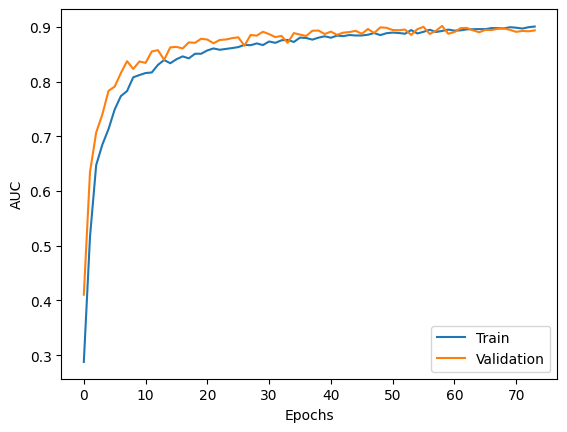

In [15]:
# Visualize the training metrics over the epochs
plt.plot(results3.history['auc'], label='Train')
plt.plot(results3.history['val_auc'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

This last model looks more balanced, so we'll be keeping this one.

# Seasonal Vaccine
## Baseline: GBDT
For Seasonal Vaccine, our best model was a GBDT instead, so let's check it's metric's performance:

In [16]:
gbdt4 = GradientBoostingClassifier(n_estimators=500,
                                   min_samples_split=6,
                                   min_samples_leaf=3,
                                   max_features="sqrt",
                                   max_depth=4,
                                   loss="log_loss",
                                   learning_rate=0.03,
                                   criterion="friedman_mse")

gbdt4_cv = cross_validate(gbdt4, X_train_raw, y_train_raw["seasonal_vaccine"].values.ravel(), cv=kf,
                       scoring=scores, return_train_score=True)

print_metrics(gbdt4_cv)

Train roc_auc: 91.0%
Train balanced_accuracy: 83.1%
Train precision: 83.1%
Train recall: 80.0%
Train f1: 81.5%
Train accuracy: 83.4%

Validation roc_auc: 85.8%
Validation balanced_accuracy: 77.9%
Validation precision: 77.3%
Validation recall: 74.2%
Validation f1: 75.7%
Validation accuracy: 78.2%


## Neural Network Models:

In [17]:
# define the keras model
model4 = Sequential()
model4.add(Input(shape=(X_train_raw.shape[1],)))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(2, activation='softmax'))

model4.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['auc'])

# fit the keras model on the dataset
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
results4 = model4.fit(X_train_raw, pd.get_dummies(y_train_raw["seasonal_vaccine"]), epochs=150, batch_size=64,
                     validation_split=0.15, callbacks=[es])


# evaluate the keras model
_, auc4 = model4.evaluate(X_test_raw, pd.get_dummies(y_test_raw["seasonal_vaccine"]))
print('Test AUC: %.2f' % (auc4*100))

Epoch 1/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.5770 - loss: 0.6850 - val_auc: 0.5900 - val_loss: 0.6819
Epoch 2/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6361 - loss: 0.6725 - val_auc: 0.6485 - val_loss: 0.6682
Epoch 3/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6959 - loss: 0.6567 - val_auc: 0.6890 - val_loss: 0.6554
Epoch 4/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7114 - loss: 0.6489 - val_auc: 0.7152 - val_loss: 0.6440
Epoch 5/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7352 - loss: 0.6372 - val_auc: 0.7318 - val_loss: 0.6335
Epoch 6/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7516 - loss: 0.6264 - val_auc: 0.7453 - val_loss: 0.6236
Epoch 7/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7555 - loss: 0.6191 - val_auc: 0.7541 - val_loss: 0.6146
Epoch 8/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7705 - loss: 0.6066 - val_auc: 0.7616 - val_loss: 0.6062
Epoch 9/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7597

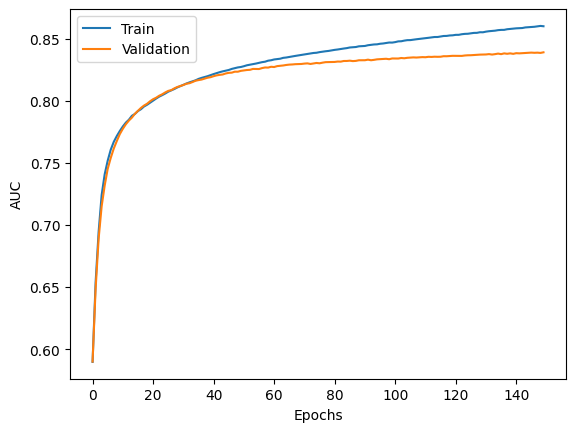

In [18]:
# Visualize the training metrics over the epochs
plt.plot(results4.history['auc'], label='Train')
plt.plot(results4.history['val_auc'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

We've spected a bit better performance, as this is the flue variant that has more balanced result. Let's try increasing the complexity of the model.

In [19]:
# define the keras model
model5 = Sequential()
model5.add(Input(shape=(X_train_raw.shape[1],)))
model5.add(Dense(1024, activation='relu'))
model5.add(Dense(1024, activation='relu'))
model5.add(Dense(1024, activation='relu'))
model5.add(Dense(1024, activation='relu'))
model5.add(Dense(2, activation='softmax'))

model5.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['auc'])

# fit the keras model on the dataset
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
results5 = model5.fit(X_train_raw, pd.get_dummies(y_train_raw["seasonal_vaccine"]), epochs=150, batch_size=64,
                     validation_split=0.15, callbacks=[es])


# evaluate the keras model
_, auc5 = model5.evaluate(X_test_raw, pd.get_dummies(y_test_raw["seasonal_vaccine"]))
print('Test AUC: %.2f' % (auc4*100))

Epoch 1/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.6249 - loss: 0.6775 - val_auc: 0.8054 - val_loss: 0.6062
Epoch 2/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.7895 - loss: 0.5974 - val_auc: 0.8175 - val_loss: 0.5483
Epoch 3/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - auc: 0.7989 - loss: 0.5553 - val_auc: 0.8234 - val_loss: 0.5268
Epoch 4/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8137 - loss: 0.5324 - val_auc: 0.8285 - val_loss: 0.5179
Epoch 5/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - auc: 0.8224 - loss: 0.5224 - val_auc: 0.8322 - val_loss: 0.5114
Epoch 6/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - auc: 0.8225 - loss: 0.5201 - val_auc: 0.8308 - val_loss: 0.5111
Epoch 7/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8337 - loss: 0.5051 - val_auc: 0.8373 - val_loss: 0.5033
Epoch 8/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8471 - loss: 0.4906 - val_auc: 0.8373 - val_loss: 0.5023
Epoch 9/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - au

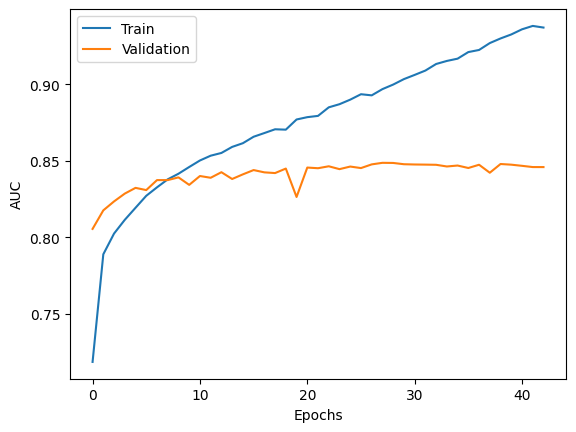

In [20]:
# Visualize the training metrics over the epochs
plt.plot(results5.history['auc'], label='Train')
plt.plot(results5.history['val_auc'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

We haven't impoved a sinlge bit, so let's try tho opposite:

In [23]:
# define the keras model
model6 = Sequential()
model6.add(Input(shape=(X_train_raw.shape[1],)))
model6.add(Dense(64, activation='relu'))
model6.add(Dense(32, activation='relu'))
model6.add(Dense(32, activation='relu'))
model6.add(Dense(2, activation='softmax'))

model6.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['auc'])

# fit the keras model on the dataset
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
results6 = model6.fit(X_train_raw, pd.get_dummies(y_train_raw["seasonal_vaccine"]), epochs=300, batch_size=64,
                     validation_split=0.15, callbacks=[es])


# evaluate the keras model
_, auc6 = model6.evaluate(X_test_raw, pd.get_dummies(y_test_raw["seasonal_vaccine"]))
print('Test AUC: %.2f' % (auc6*100))

Epoch 1/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.4751 - loss: 0.7091 - val_auc: 0.4639 - val_loss: 0.7077
Epoch 2/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.4725 - loss: 0.7075 - val_auc: 0.4791 - val_loss: 0.7037
Epoch 3/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.4904 - loss: 0.7037 - val_auc: 0.4978 - val_loss: 0.6997
Epoch 4/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.5046 - loss: 0.6999 - val_auc: 0.5143 - val_loss: 0.6958
Epoch 5/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.5267 - loss: 0.6947 - val_auc: 0.5328 - val_loss: 0.6921
Epoch 6/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.5284 - loss: 0.6942 - val_auc: 0.5484 - val_loss: 0.6884
Epoch 7/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.5593 - loss: 0.6881 - val_auc: 0.5649 - val_loss: 0.6848
Epoch 8/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.5722 - loss: 0.6847 - val_auc: 0.5817 - val_loss: 0.6811
Epoch 9/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.5894

In [ ]:
# Visualize the training metrics over the epochs
plt.plot(results5.history['auc'], label='Train')
plt.plot(results5.history['val_auc'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

We'll choose the first model.

# Testing the models:

In [27]:
y_test_h1n1 = model3.predict(X_test_raw)[:,1]
y_test_seas = model4.predict(X_test_raw)[:,1]
h1n1_score = roc_auc_score(y_test_raw['h1n1_vaccine'], y_test_h1n1)
seas_score = roc_auc_score(y_test_raw['seasonal_vaccine'], y_test_seas)

print(f"H1N1 Socre: {round(h1n1_score,4)}")
print(f"Seasonal Socre: {round(seas_score,4)}")
print(f"Global Socre: {round(((h1n1_score + seas_score) / 2) ,4)}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
H1N1 Socre: 0.8223
Seasonal Socre: 0.8378
Global Socre: 0.83


# Training models with the whole Dataset:

In [36]:
# H1N1 Model:
h1n1_model = Sequential()
h1n1_model.add(Input(shape=(X_train_raw.shape[1],)))
h1n1_model.add(Dense(32, activation='relu'))
h1n1_model.add(Dense(16, activation='relu'))
h1n1_model.add(Dense(8, activation='relu'))
h1n1_model.add(Dense(2, activation='softmax'))

h1n1_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['auc'])

# fit the keras model on the dataset
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

results_h1n1 = h1n1_model.fit(X_raw, pd.get_dummies(y_raw["h1n1_vaccine"]), epochs=300, batch_size=64,
                     validation_split=0.2, callbacks=[es], class_weight=class_weights)

Epoch 1/300
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.6250 - loss: 0.9908 - val_auc: 0.5900 - val_loss: 0.6712
Epoch 2/300
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.5983 - loss: 0.9506 - val_auc: 0.6280 - val_loss: 0.6533
Epoch 3/300
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6661 - loss: 0.9114 - val_auc: 0.6731 - val_loss: 0.6307
Epoch 4/300
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6838 - loss: 0.8948 - val_auc: 0.7137 - val_loss: 0.6066
Epoch 5/300
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7319 - loss: 0.8575 - val_auc: 0.7306 - val_loss: 0.5958
Epoch 6/300
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7661 - loss: 0.8160 - val_auc: 0.7515 - val_loss: 0.5815
Epoch 7/300
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7771 - loss: 0.8030 - val_auc: 0.7613 - val_loss: 0.5739
Epoch 8/300
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7839 - loss: 0.7962 - val_auc: 0.7860 - val_loss: 0.5522
Epoch 9/300
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

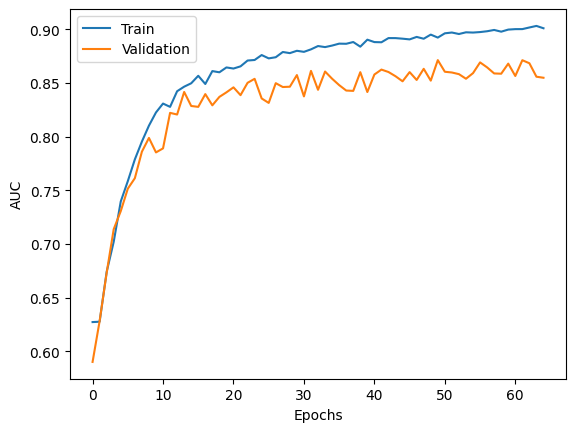

In [37]:
# Visualize the training metrics over the epochs
plt.plot(results_h1n1.history['auc'], label='Train')
plt.plot(results_h1n1.history['val_auc'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [28]:
# Seasonal Model:
seas_model = Sequential()
seas_model.add(Input(shape=(X_train_raw.shape[1],)))
seas_model.add(Dense(128, activation='relu'))
seas_model.add(Dense(128, activation='relu'))
seas_model.add(Dense(128, activation='relu'))
seas_model.add(Dense(2, activation='softmax'))

seas_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['auc'])

# fit the keras model on the dataset
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
results_seas = seas_model.fit(X_raw, pd.get_dummies(y_raw["seasonal_vaccine"]), epochs=150, batch_size=64,
                     validation_split=0.15, callbacks=[es])


Epoch 1/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.6132 - loss: 0.6736 - val_auc: 0.6885 - val_loss: 0.6628
Epoch 2/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7103 - loss: 0.6577 - val_auc: 0.7256 - val_loss: 0.6496
Epoch 3/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7374 - loss: 0.6451 - val_auc: 0.7468 - val_loss: 0.6373
Epoch 4/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7626 - loss: 0.6307 - val_auc: 0.7586 - val_loss: 0.6258
Epoch 5/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7706 - loss: 0.6200 - val_auc: 0.7657 - val_loss: 0.6150
Epoch 6/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7758 - loss: 0.6105 - val_auc: 0.7712 - val_loss: 0.6053
Epoch 7/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7866 - loss: 0.5964 - val_auc: 0.7743 - val_loss: 0.5967
Epoch 8/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7790 - loss: 0.5941 - val_auc: 0.7792 - val_loss: 0.5886
Epoch 9/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

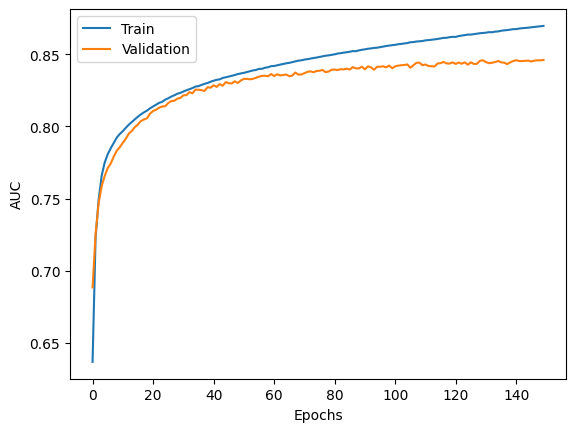

In [31]:
# Visualize the training metrics over the epochs
plt.plot(results_seas.history['auc'], label='Train')
plt.plot(results_seas.history['val_auc'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Saving Models:

In [39]:
import pickle

In [40]:
with open('Models/nn_model_h1n1.pkl', 'wb') as nn_h1n1:
    pickle.dump(h1n1_model, nn_h1n1)
    
with open('Models/nn_model_seasonal.pkl', 'wb') as nn_seas:
    pickle.dump(seas_model, nn_seas)

### Test:
Saving just the first model for H1N1 vaccine, without trining it with the whole Dataset, as it seems to be a bit more robust.

In [41]:
with open('Models/nn_hf_model_h1n1.pkl', 'wb') as nn_h1n1:
    pickle.dump(model3, nn_h1n1)

# Neural Networ for both Vaccines at the time:

In [134]:
# define the keras model
model_tot = Sequential()
model_tot.add(Input(shape=(X_train_raw.shape[1],)))
model_tot.add(Dense(64, activation='relu'))
model_tot.add(Dense(32, activation='relu'))
model_tot.add(Dense(16, activation='relu'))
model_tot.add(Dense(2, activation='sigmoid'))

model_tot.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=["auc"])

# fit the keras model on the dataset
results_tot = model_tot.fit(X_train_raw, y_train_raw, epochs=150, batch_size=64,
                     validation_split=0.2, callbacks=[es])




# evaluate the keras model
_, auc_tot = model_tot.evaluate(X_test_raw, y_test_raw)
print('Test BinaryAccuracy: %.2f' % (auc_tot*100))

Epoch 1/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.6977 - loss: 0.4369 - val_auc: 0.6836 - val_loss: 0.4267
Epoch 2/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6957 - loss: 0.4266 - val_auc: 0.6824 - val_loss: 0.4251
Epoch 3/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6898 - loss: 0.4319 - val_auc: 0.6816 - val_loss: 0.4238
Epoch 4/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7065 - loss: 0.4342 - val_auc: 0.6804 - val_loss: 0.4228
Epoch 5/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6897 - loss: 0.4286 - val_auc: 0.6788 - val_loss: 0.4219
Epoch 6/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6974 - loss: 0.4107 - val_auc: 0.6781 - val_loss: 0.4211
Epoch 7/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6786 - loss: 0.4348 - val_auc: 0.6771 - val_loss: 0.4205
Epoch 8/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6855 - loss: 0.4420 - val_auc: 0.6765 - val_loss: 0.4201
Epoch 9/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6845

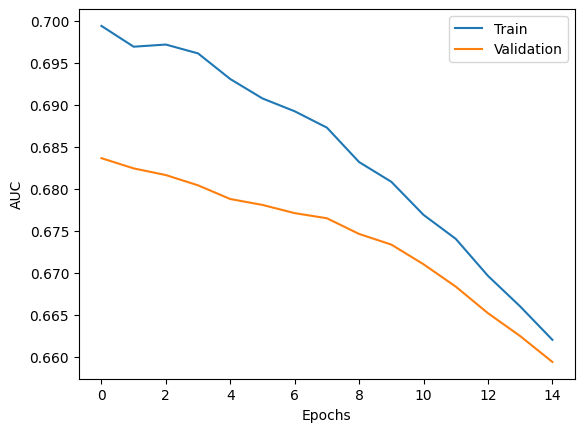

In [136]:
# Visualize the training metrics over the epochs
plt.plot(results_tot.history['auc'], label='Train')
plt.plot(results_tot.history['val_auc'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

Awfull performance, so we should dismiss this model.